# Model inference

Here, we show how to load an already trained/fine-tuned model and a dataset and then do model inference.

In [1]:
# solve issue with autocomplete
%config Completer.use_jedi = False

%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import glob
import matplotlib.pyplot as plt
import os
from scipy.interpolate import griddata

## Load patches and add metadata

In [3]:
from mapreader import load_patches

In [4]:
my_files = load_patches("./dataset/open_access_plant/slice_50_50/*PNG", 
                      parent_paths="./dataset/open_access_plant/*png")

In [6]:
parent_df, patch_df = my_files.convertImages()
patch_df.head()

,parent_id,image_path,min_x,min_y,max_x,max_y
patch-100-400-150-450-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,400,150,450
patch-100-500-150-530-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,500,150,530
patch-50-100-100-150-#2014-07-17_plant047_rgb.png#.PNG,2014-07-17_plant047_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,50,100,100,150
patch-100-300-150-350-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,300,150,350
patch-0-200-50-250-#2014-06-06_plant001_rgb.png#.PNG,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,0,200,50,250


In [7]:
patch_df.reset_index(names="image_id", inplace=True)
patch_df.head()

,image_id,parent_id,image_path,min_x,min_y,max_x,max_y
0,patch-100-400-150-450-#2014-06-06_plant001_rgb...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,400,150,450
1,patch-100-500-150-530-#2014-06-06_plant001_rgb...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,500,150,530
2,patch-50-100-100-150-#2014-07-17_plant047_rgb....,2014-07-17_plant047_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,50,100,100,150
3,patch-100-300-150-350-#2014-06-06_plant001_rgb...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,300,150,350
4,patch-0-200-50-250-#2014-06-06_plant001_rgb.pn...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,0,200,50,250


## Select patches for inference and create dataset

In [8]:
import numpy as np
from torchvision import transforms
from mapreader import patchTorchDataset

In [18]:
resize = (224,224)
normalize_mean = [0.485, 0.456, 0.406]
normalize_std = [0.229, 0.224, 0.225]

data_transforms = transforms.Compose([transforms.Resize(resize), 
                                      transforms.ToTensor(), 
                                      transforms.Normalize(normalize_mean,normalize_std)])

In [19]:
patches2infer = patch_df[["image_path"]]
patches2infer

,image_path
0,/Users/rwood/LwM/MapReader/worked_examples/non...
1,/Users/rwood/LwM/MapReader/worked_examples/non...
2,/Users/rwood/LwM/MapReader/worked_examples/non...
3,/Users/rwood/LwM/MapReader/worked_examples/non...
4,/Users/rwood/LwM/MapReader/worked_examples/non...
...,...
215,/Users/rwood/LwM/MapReader/worked_examples/non...
216,/Users/rwood/LwM/MapReader/worked_examples/non...
217,/Users/rwood/LwM/MapReader/worked_examples/non...
218,/Users/rwood/LwM/MapReader/worked_examples/non...


In [20]:
patches2infer_dataset = patchTorchDataset(patches2infer, 
                                          transform=data_transforms)

## Load your pre-trained model

In [21]:
from mapreader import classifier

In [22]:
my_classifier = classifier()

my_classifier.load("./models_plant_open/checkpoint_7.pkl")

[INFO] Device is set to cpu


In [23]:
batch_size=64

my_classifier.add2dataloader(patches2infer_dataset, 
                            set_name="infer_test", 
                            batch_size=batch_size, 
                            shuffle=False)

[INFO] added 'infer_test' dataloader with 220 elements.


In [24]:
my_classifier.batch_info(set_name='infer_test')

[INFO] dataset: infer_test
#samples:    220
#batch size: 64
#batches:    4



## Inference

In [25]:
my_classifier.inference(set_name="infer_test")

2023-03-08 14:15:50 JY5FK6W3K5 [INFO] infer_test -- 11/11 --      64/220 ( 29.1%) -- 
Total time: 0m 6s


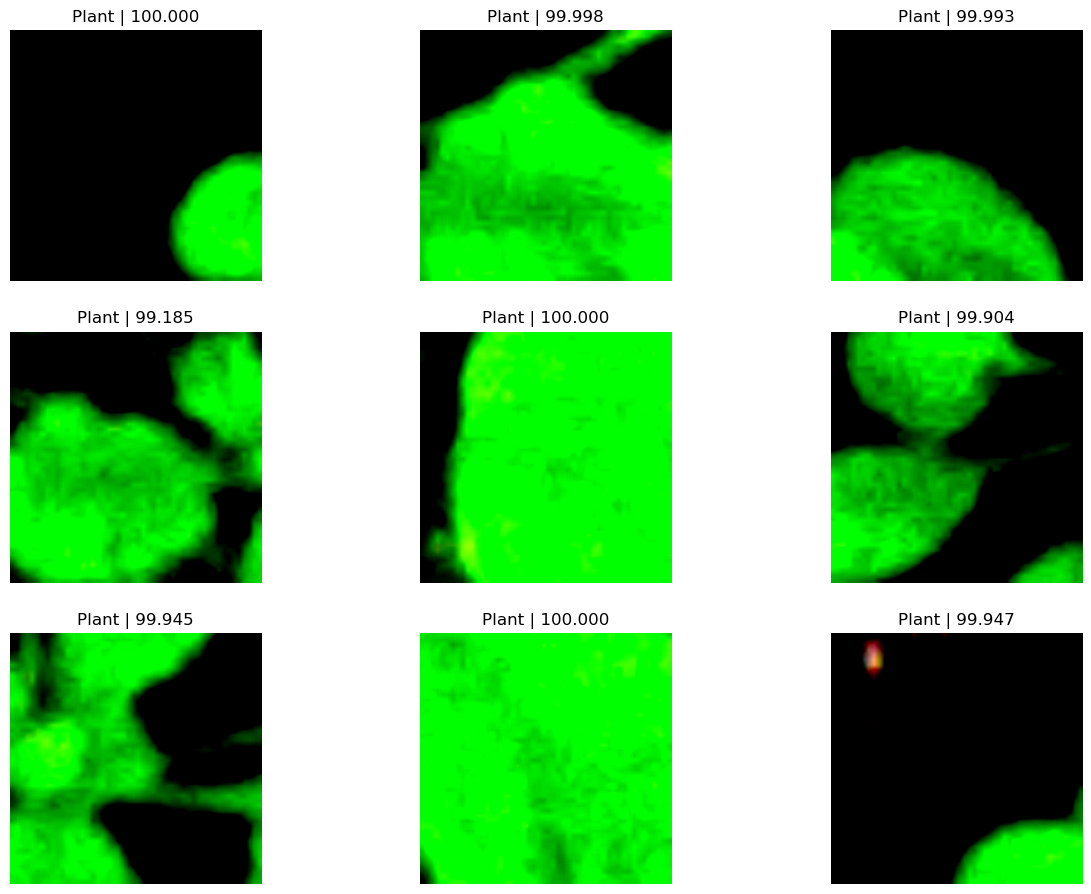

In [26]:
my_classifier.inference_sample_results(num_samples=9, 
                                       class_index=1, 
                                       set_name="infer_test", 
                                       min_conf=80)

## Add model inference outputs to `mapImages`

In [27]:
patches2infer['pred'] = my_classifier.pred_label
patches2infer['conf'] = np.max(np.array(my_classifier.pred_conf), axis=1)
patches2infer


,image_path,pred,conf
0,/Users/rwood/LwM/MapReader/worked_examples/non...,0,0.997204
1,/Users/rwood/LwM/MapReader/worked_examples/non...,0,0.997405
2,/Users/rwood/LwM/MapReader/worked_examples/non...,0,0.997187
3,/Users/rwood/LwM/MapReader/worked_examples/non...,1,1.000000
4,/Users/rwood/LwM/MapReader/worked_examples/non...,0,0.997561
...,...,...,...
215,/Users/rwood/LwM/MapReader/worked_examples/non...,1,0.999987
216,/Users/rwood/LwM/MapReader/worked_examples/non...,1,1.000000
217,/Users/rwood/LwM/MapReader/worked_examples/non...,1,0.996138
218,/Users/rwood/LwM/MapReader/worked_examples/non...,0,0.993018


In [28]:
patch_df = patch_df.merge(patches2infer, 
                     how="outer",
                     on="image_path",
                     validate="1:1")

In [29]:
patch_df.head()

,image_id,parent_id,image_path,min_x,min_y,max_x,max_y,pred,conf
0,patch-100-400-150-450-#2014-06-06_plant001_rgb...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,400,150,450,0,0.997204
1,patch-100-500-150-530-#2014-06-06_plant001_rgb...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,500,150,530,0,0.997405
2,patch-50-100-100-150-#2014-07-17_plant047_rgb....,2014-07-17_plant047_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,50,100,100,150,0,0.997187
3,patch-100-300-150-350-#2014-06-06_plant001_rgb...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,100,300,150,350,1,1.000000
4,patch-0-200-50-250-#2014-06-06_plant001_rgb.pn...,2014-06-06_plant001_rgb.png,/Users/rwood/LwM/MapReader/worked_examples/non...,0,200,50,250,0,0.997561


In [30]:
my_files.add_metadata(patch_df, tree_level="child")

In [33]:
parent_list=my_files.list_parents()

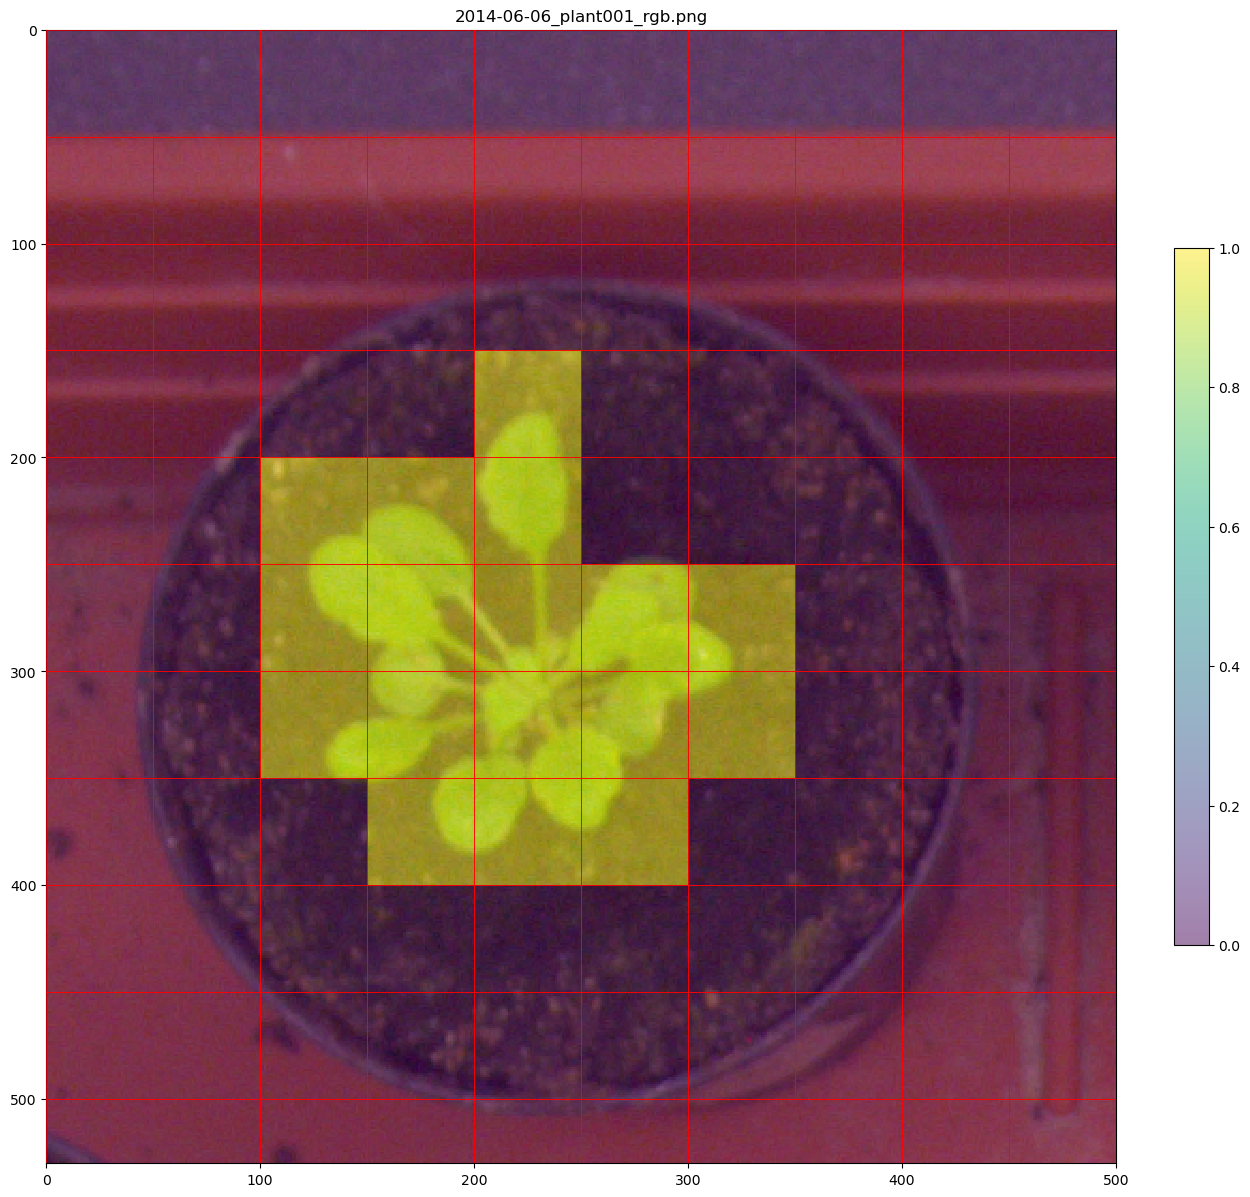

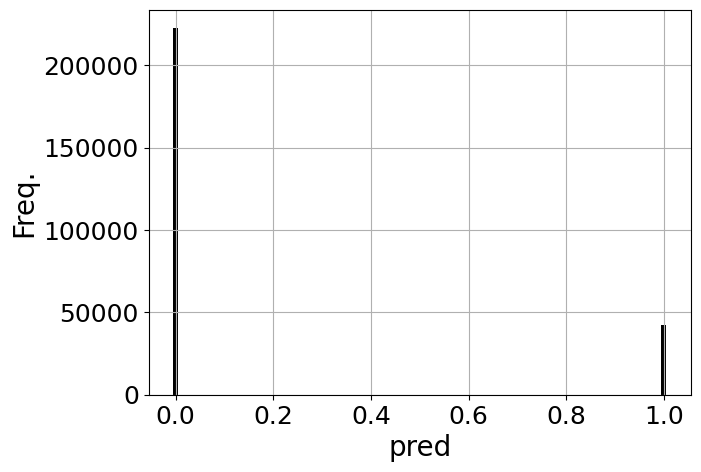

In [34]:
my_files.show_par(parent_list[0], 
                value="pred",
                border=True,
                plot_parent=True,
                vmin=0, 
                vmax=1,
                figsize=(15, 15),
                alpha=0.5, 
                colorbar="viridis")